<a href="https://colab.research.google.com/github/Henrique047/PDI_T1/blob/main/C%C3%B3pia_de_PDI_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - PREPARAÇÃO AS IMAGENS**

In [ ]:
!pip install medmnist opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [ ]:
import medmnist
from skimage.util import random_noise
from medmnist import ChestMNIST  # Você pode escolher outro conjunto de dados, se necessário
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Para exibição no Colab


In [ ]:
# Definir a versão do dataset
data_flag = "chestmnist"  # Pode ser alterado para outro dataset, como 'pathmnist', 'dermamnist', etc.
download = True

# Carregar os dados
dataset = ChestMNIST(split="test", download=download)


100%|██████████| 82.8M/82.8M [00:04<00:00, 17.2MB/s]


In [123]:

def add_salt_pepper_noise(image, amount, salt_vs_pepper=0.5):
    noisy = image.copy()

    # Quantidade total de pixels a serem afetados
    total_pixels = image.size
    num_salt = int(amount * total_pixels * salt_vs_pepper)
    num_pepper = int(amount * total_pixels * (1.0 - salt_vs_pepper))

    # Salt (255)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[tuple(coords)] = 255

    # Pepper (0)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[tuple(coords)] = 0

    return noisy


In [172]:
new_size = (200, 200)
img = dataset.imgs[1]

img = ((1-img) * 255).astype(np.uint8)
#img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

img_noise = add_salt_pepper_noise(img, amount=0.2)  # 20% de ruído
cv2_imshow(img)
cv2_imshow(img_noise)


# **2 - PRÉ-PROCESSAMENTO (EQUALIZAÇÃO DE HISTOGRAMA)**

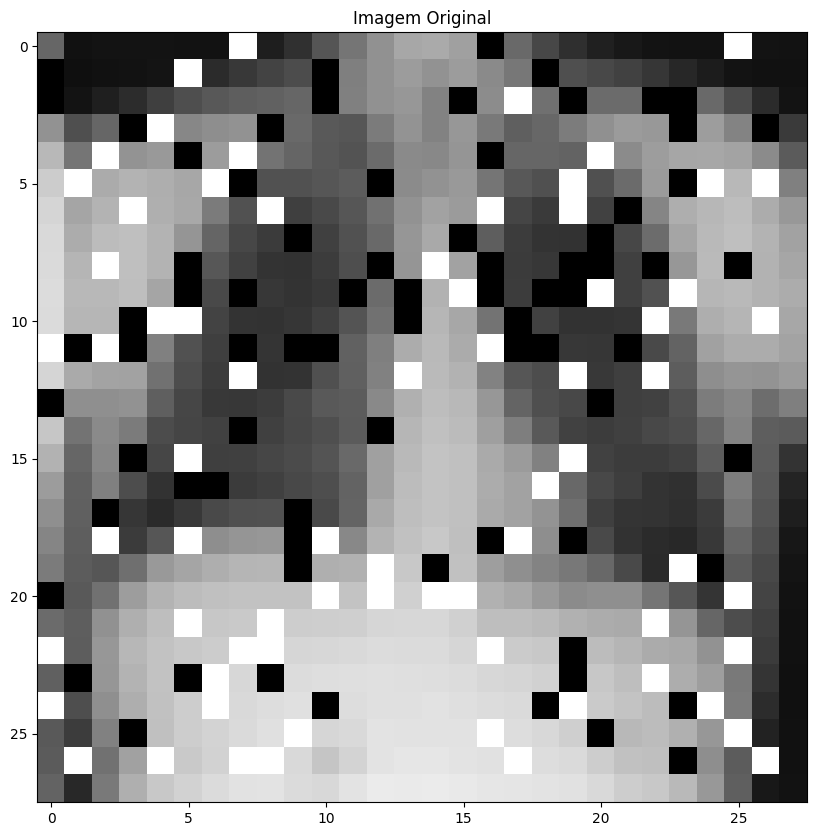

In [173]:
#Imagem original
figsize = (10, 10)
plt.figure(figsize=figsize)
plt.imshow(img_noise, cmap="gray", vmin=0, vmax=255)
plt.title("Imagem Original")
plt.show()

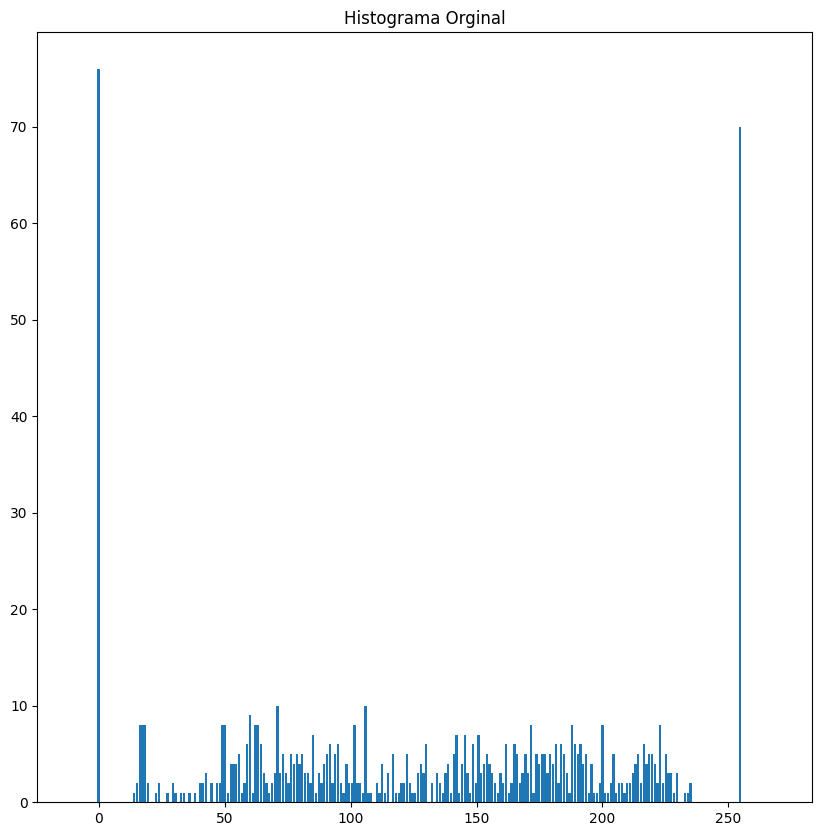

In [174]:
#Histograma original
intervalo_min_max = [-10, 270]
num_pontos = 256
point_count, point_edges = np.histogram(img_noise, num_pontos, intervalo_min_max)
point_start = point_edges[:-1]

def draw_hist(x_axis, input):
    fig, ax = plt.subplots(figsize=figsize)
    # por que não usar plt.hist? porque queremos traçar também algumas derivações desse histograma
    plt.bar(x_axis, input, width=input.shape[0] / (x_axis[-1] - x_axis[0] + 1))
    return fig, ax


draw_hist(point_start, point_count)
plt.title("Histograma Orginal")
plt.show()

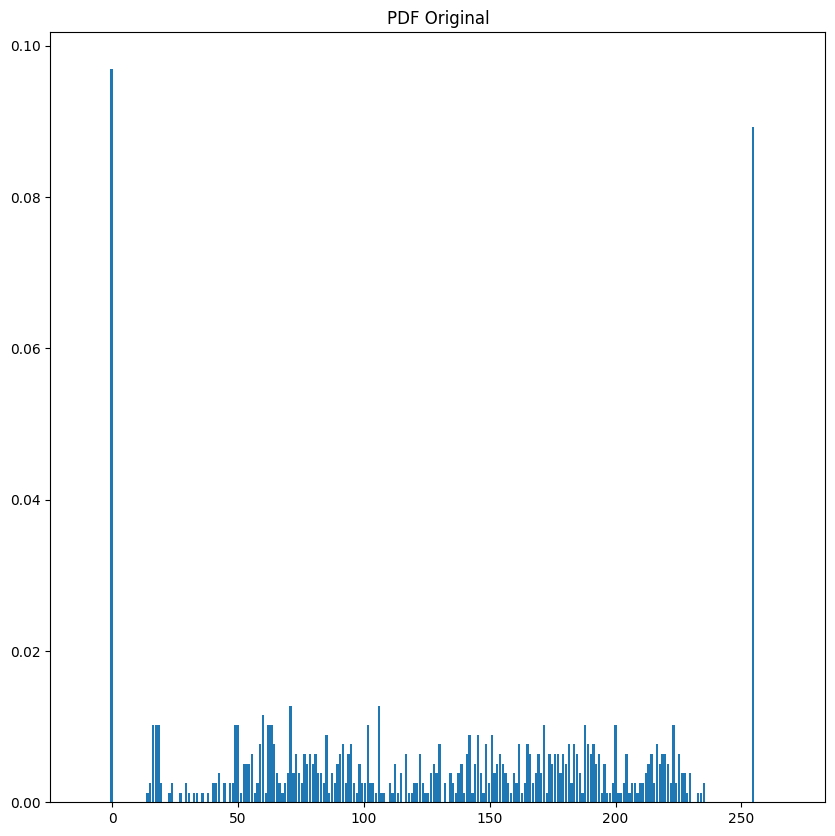

In [175]:
#Normalizamos o histograma
pdf = point_count / np.sum(point_count)

draw_hist(point_start, pdf)
plt.title("PDF Original")
plt.show()

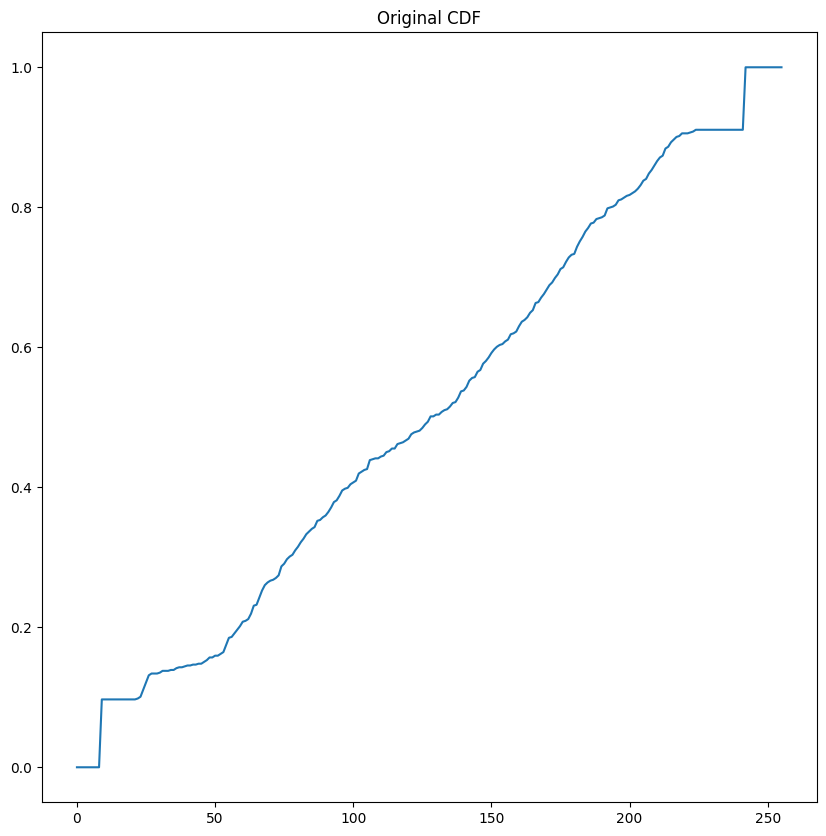

In [176]:
#Obtemos o CDF (Função densidaade cumulativa)
cdf = np.cumsum(pdf)

plt.figure(figsize=figsize)
plt.plot(cdf)
plt.title("Original CDF")
plt.show()

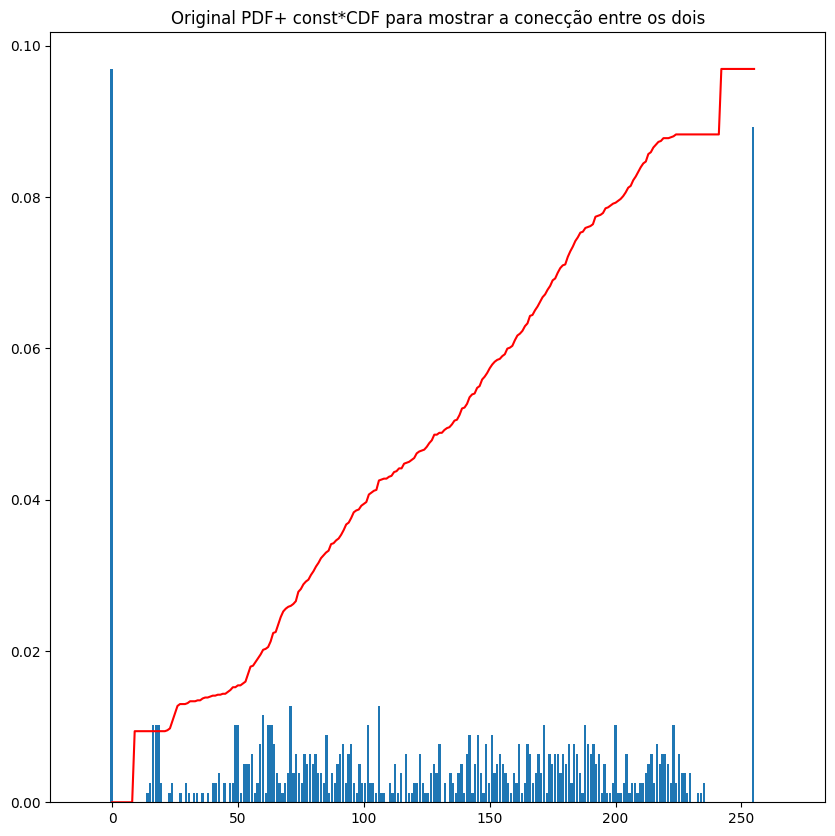

In [177]:
fig, ax = draw_hist(point_start, pdf)
ax.plot(cdf * np.max(pdf), "r")
plt.title("Original PDF+ const*CDF para mostrar a conecção entre os dois")
plt.show()

In [178]:
#Desnormalizando para tornar função de equalização
f_eq = np.round(cdf * 255).astype(int)
f_eq

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  26,  28,  31,
        34,  34,  34,  34,  34,  35,  35,  35,  35,  35,  36,  36,  36,
        37,  37,  37,  37,  37,  38,  38,  38,  39,  40,  40,  41,  41,
        41,  42,  45,  47,  47,  49,  50,  51,  53,  53,  54,  56,  59,
        59,  62,  64,  66,  67,  68,  68,  69,  70,  73,  74,  76,  77,
        77,  79,  80,  82,  83,  85,  86,  87,  87,  90,  90,  91,  92,
        93,  95,  97,  97,  99, 101, 101, 102, 103, 104, 104, 107, 108,
       108, 109, 112, 112, 113, 113, 113, 114, 115, 115, 116, 116, 118,
       118, 118, 119, 120, 121, 122, 122, 123, 124, 125, 126, 128, 128,
       128, 128, 129, 130, 130, 131, 133, 133, 135, 137, 137, 139, 141,
       142, 142, 144, 145, 147, 148, 149, 151, 152, 153, 154, 154, 155,
       156, 158, 158, 159, 161, 162, 163, 164, 166, 167, 169, 169, 171,
       172, 174, 176, 177, 178, 180, 181, 182, 184, 186, 187, 18

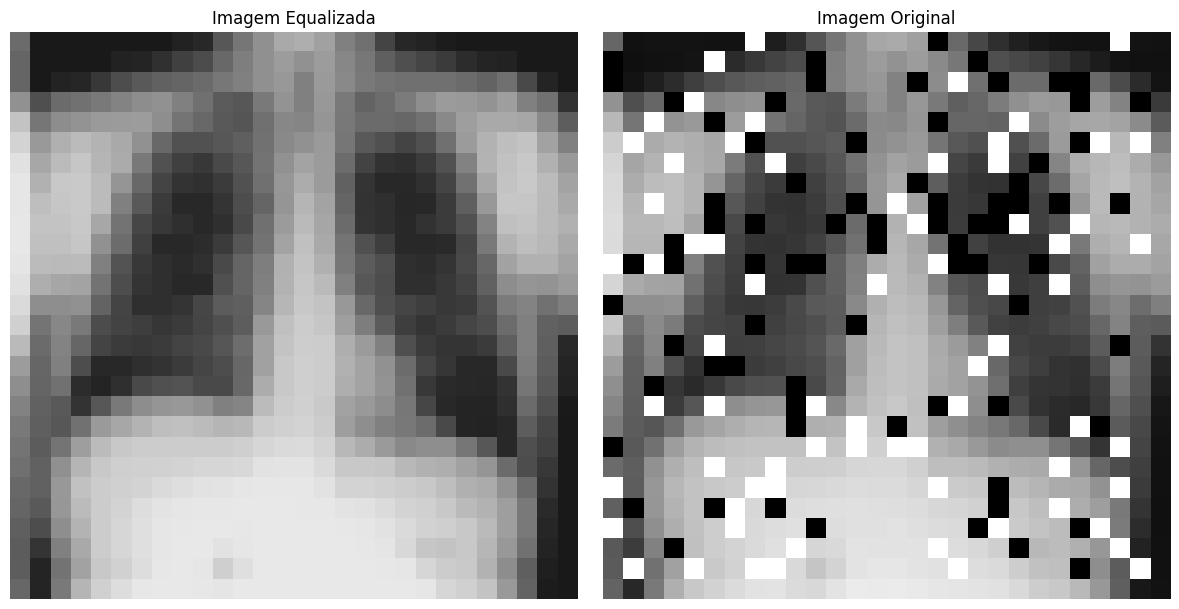

In [179]:
# Define o tamanho total da figura (horizontal maior)
img_eq = f_eq[img]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha, 2 colunas

# Imagem equalizada
axs[0].imshow(img_eq, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Imagem Equalizada')
axs[0].axis('off')  # remove os eixos

# Imagem original
axs[1].imshow(img_noise, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Imagem Original')
axs[1].axis('off')

# Mostra tudo junto
plt.tight_layout()
plt.show()

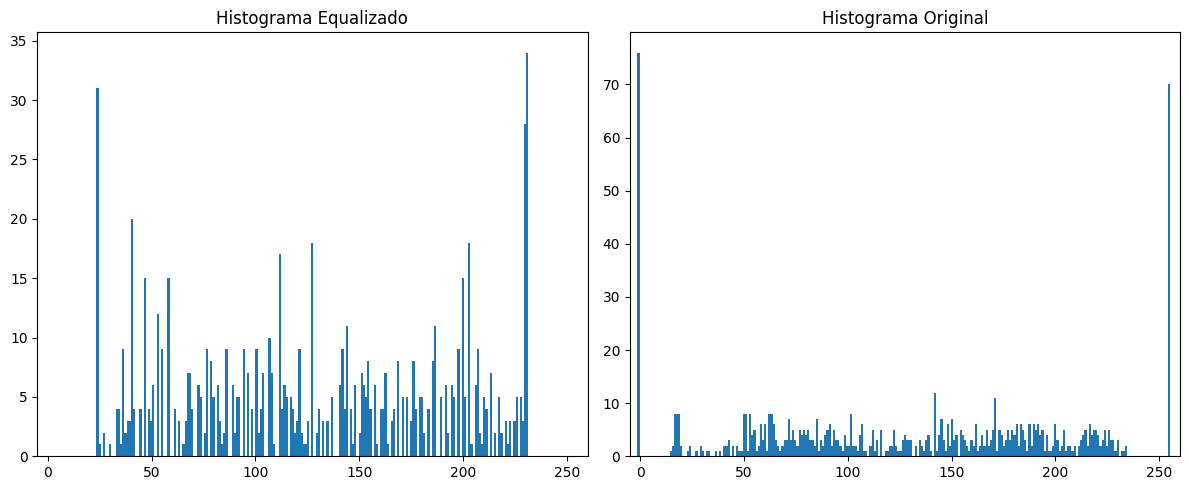

In [228]:

# Definindo o intervalo e número de pontos
intervalo_min_max = [-5, 260]
num_pontos = 256
figsize = (12, 5)  # Tamanho dos gráficos

# Histograma equalizado
bin_count, bins_edges = np.histogram(img_eq, num_pontos, intervalo_min_max)
bins_start = bins_edges[:-1]

# Histograma original (com ruído)
point_count, point_edges = np.histogram(img_noise, num_pontos, intervalo_min_max)
point_start = point_edges[:-1]

# Criação do gráfico lado a lado
fig, axs = plt.subplots(1, 2, figsize=figsize)

# Função para desenhar cada histograma num eixo específico
def draw_hist2(x_axis, input_data, ax, title):
    width = (x_axis[1] - x_axis[0])
    ax.bar(x_axis, input_data, width=width)
    ax.set_title(title)
    ax.set_xlim(intervalo_min_max)

# Desenha os dois histogramas
draw_hist2(bins_start, bin_count, axs[0], "Histograma Equalizado")
draw_hist2(point_start, point_count, axs[1], "Histograma Original")


plt.tight_layout()
plt.show()


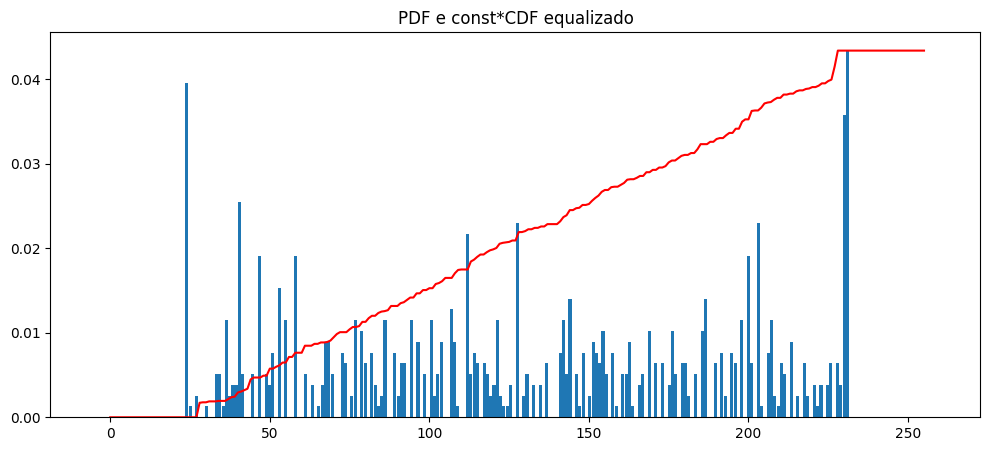

In [229]:

pdf = bin_count / np.sum(point_count)
cdf = np.cumsum(pdf)

fig, ax = draw_hist(bins_start, pdf)
ax.plot(cdf * np.max(pdf), "r")
plt.title("PDF e const*CDF equalizado")
plt.show()

# **2 - PRÉ-PROCESSAMENTO (CORREÇÃO DE GAMMA)**

In [294]:
#gamma
img_in = img_eq

c = 1 #255/(np.log(1 + np.max(img_eq)))
gamma = 1.4
#img_out = np.array(c*255**(img_in/255) ** gamma, dtype = np.uint8)
img_out = np.array(c*255*(img_in/255)**gamma, dtype = np.uint8)

print(img_out.max())

cv2_imshow(img_in)
cv2_imshow(img_out)

223


# **3 - REDUÇÃO E RUÍDO (GAUSSIANO)**

In [231]:
def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

In [232]:
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.uint8)

In [233]:
def gauss_create(sigma=1, size_x=3, size_y=3):
    '''
    Create normal (gaussian) distribuiton
    '''
    x, y = np.meshgrid(np.linspace(-1,1,size_x), np.linspace(-1,1,size_y))
    calc = 1/((2*np.pi*(sigma**2)))
    exp = np.exp(-(((x**2) + (y**2))/(2*(sigma**2))))

    return exp*calc

In [302]:

#gaussiano
gaus_3x3 = gauss_create(sigma=1, size_x=3, size_y=3)
gaus_5x5 = gauss_create(sigma=1.9, size_x=5, size_y=5)
gaus_7x7 = gauss_create(sigma=2.7, size_x=7, size_y=7)

img_g3 = conv2d(img_out, gaus_3x3)
img_g5 = conv2d(img_out, gaus_5x5)
img_g7 = conv2d(img_out, gaus_7x7)

img_galt = conv2d(laplace_final, gaus_5x5)

print("Imagem original")
cv2_imshow(img_out)
print("Imagem com filtro Gaussiano 3x3")
cv2_imshow(img_g3)
print("Imagem com filtro Gaussiano 5x5")
cv2_imshow(img_g5)
print("Imagem com filtro Gaussiano 7x7(mais borrado)")
cv2_imshow(img_g7)
print("Imagem alternativa com filtro Gaussiano 3x3")
cv2_imshow(img_galt)



Imagem original


Imagem com filtro Gaussiano 3x3


Imagem com filtro Gaussiano 5x5


Imagem com filtro Gaussiano 7x7(mais borrado)


Imagem alternativa com filtro Gaussiano 3x3


# **3 - REDUÇÃO E RUÍDO (MEDIANA)**

In [235]:
def bubble_sort(arr):

    # Outer loop to iterate through the list n times
    for n in range(len(arr) - 1, 0, -1):

        # Inner loop to compare adjacent elements
        for i in range(n):
            if arr[i] > arr[i + 1]:

                # Swap elements if they are in the wrong order
                swapped = True
                arr[i], arr[i + 1] = arr[i + 1], arr[i]
    return arr

In [236]:
def medianFilter(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img
    else:
        padded_img = img
    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output
    kernel_vectorized = np.zeros(k_height*k_width)
    #print(kernel_vectorized)
    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            i_vector = 0
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    kernel_vectorized[i_vector] = padded_img[i_img+i_kernel, j_img+j_kernel]  # Atribui valor à variável output[i, j]
                    i_vector+=1
            kernel_vectorized = bubble_sort(kernel_vectorized)
            median_index = int(((k_height*k_width)/2)+1)
            output[i_img, j_img] = int(kernel_vectorized[median_index])

    return np.array(output, dtype=np.uint8)

In [274]:
#Mediana
med_3x3 = np.ones((3,3))
med_5x5 = np.ones((5,5))
med_7x7 = np.ones((7,7))

img_med3 = medianFilter(img_out, med_3x3, padding=True)
img_med5 = medianFilter(img_out, med_5x5, padding=True)
img_med7 = medianFilter(img_out, med_7x7, padding=True)

img_alt = medianFilter(laplace_final, med_5x5, padding=True)


print("Imagem Original")
cv2_imshow(img_out)
print("Imagem com filtro Mediana 3x3")
cv2_imshow(img_med3)
print("Imagem com filtro Mediana 5x5")
cv2_imshow(img_med5)
print("Imagem com filtro Mediana 7x7")
cv2_imshow(img_med7)
print("Imagem alternativa com filtro Mediana 3x3")
cv2_imshow(img_alt)


Imagem Original


Imagem com filtro Mediana 3x3


Imagem com filtro Mediana 5x5


Imagem com filtro Mediana 7x7


Imagem alternativa com filtro Mediana 3x3


# **4 - REALCE DE BORDAS (LAPLACIANO)**

In [ ]:
def conv2d_sharpening(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            #calcula kernel
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.float32)

In [296]:
kernel_laplaciano = np.array(([0,1,0],[1,-4,1],[0,1,0]))

laplacianomed = conv2d_sharpening(img_med3, kernel_laplaciano)
laplacianomed = np.clip(laplacianomed, 0, 255).astype(np.uint8)

laplacianogaus = conv2d_sharpening(img_g3, kernel_laplaciano)
laplacianogaus = np.clip(laplacianogaus, 0, 255).astype(np.uint8)

laplace = conv2d_sharpening(img_out, kernel_laplaciano)


laplace_final = img_out - laplace  # ou +, dependendo do efeito desejado
laplace_final = np.clip(laplace_final, 0, 255).astype(np.uint8)

img_realcadag = img_g3 - laplacianogaus  # ou +, dependendo do efeito desejado
img_realcadag = np.clip(img_realcadag, 0, 255).astype(np.uint8)

img_realcadam = img_med3 - laplacianomed  # ou +, dependendo do efeito desejado
img_realcadam = np.clip(img_realcadam, 0, 255).astype(np.uint8)

print("Imagem equalizada")
cv2_imshow(img_eq)
print("Imagem com gamma corrigio")
cv2_imshow(img_out)
print("imagem alternativa somente com realce apos gamma")
cv2_imshow(laplace_final)
print("imagem realcadda após gaussiano")
cv2_imshow(img_realcadag)
print("imagem realcadda após mediana")
cv2_imshow(img_realcadam)

Imagem equalizada


Imagem com gamma corrigio


imagem alternativa somente com realce apos gamma


imagem realcadda após gaussiano


imagem realcadda após mediana


# **4 - REALCE DE BORDAS (SOBEL)**

In [279]:
kernel_sobel_1 = np.array(([-1,-2,-1],[0,0,0],[1,2,1]))
kernel_sobel_2 = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))

img_sobel_1 = conv2d_sharpening(img_med3, kernel_sobel_1)
img_sobel_2 = conv2d_sharpening(img_med3, kernel_sobel_2)

def normaliza_img(img):
    img = np.abs(img).astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val == min_val:
        return np.zeros_like(img, dtype=np.uint8)
    norm_img = 255 * (img - min_val) / (max_val - min_val)
    return norm_img.astype(np.uint8)

img_sobel = np.abs(img_sobel_1)+np.abs(img_sobel_2)
img_sobel_norm = normaliza_img(img_sobel)

imagem_realcada =  img_med3 - img_sobel_norm
imagem_realcada = np.clip(imagem_realcada, 0, 255).astype(np.uint8)

cv2_imshow(img_sobel)
cv2_imshow(img_sobel_norm)
cv2_imshow(imagem_realcada)




# **5 - AJUSTE FINAL (HIGH-BOOST FILTERING)**

In [303]:
original = laplace_final
A = 1.5
suavizada = img_galt


highboost = ((1+A) * original.astype(float)) - (A * suavizada.astype(float))
highboost = np.clip(highboost, 0, 255).astype(np.uint8)


cv2_imshow(img_galt)
cv2_imshow(laplace_final)
cv2_imshow(highboost)
